### Extract zipfiles

In [23]:
from zipfile import ZipFile

parent_dir = "kagglecatsanddogs_3367a.zip"
kaggle = ZipFile(parent_dir)

In [62]:
kaggle.extractall("PetImages/")

In [1]:
dogs = "PetImages/PetImages/Dog/"
cats = "PetImages/PetImages/Cat/"

### Note that PetImages/ is not separated into train and val.

In [2]:
import glob

# This is how we will receive images
dog_images = glob.glob(dogs + "/*.jpg")
cat_images = glob.glob(cats + "/*.jpg")

In [66]:
assert type(dog_images) == list

In [32]:
len(dog_images)

12500

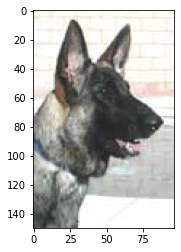

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 12500 dog images
plt.imshow(mpimg.imread(dog_images[12499]))

### Create train and val folders that are labeled

In [81]:
import os

train_path = "train"
val_path = "validate"

# Set of all directories
subDirs = set(("Dog", "Cat"))

def createSubDirs(subDirs, *paths):
    dirDict = dict()
    for path in paths:
        path = os.getcwd() + "\\" + path
        try:
            os.mkdir(path)
            dirDict[path] = []
        except OSError:
            print ("Creation of the directory %s failed" % path)
        except Exception as e:
            # Logging later
            print(e)
        else:
            
            for sub in subDirs:
                os.mkdir(path + "\\" + sub)
                dirDict.get(path).append(sub)
            
            print ("Successfully created the directory %s " % path)
            print(os.walk(path))
            
        finally:
            pass  # Maybe print all directories? Optional.
    
    return dirDict

dirDict = createSubDirs(subDirs, train_path, val_path)

Successfully created the directory C:\Users\leode\train 
<generator object walk at 0x00000285CEC973C0>
Successfully created the directory C:\Users\leode\validate 
<generator object walk at 0x00000285CEC97BA0>


In [82]:
dirDict

{'C:\\Users\\leode\\train': ['Dog', 'Cat'],
 'C:\\Users\\leode\\validate': ['Dog', 'Cat']}

### Add in images of dogs and cats to both train and val

In [6]:
from sklearn.model_selection import train_test_split

dog_train, dog_test, cat_train, cat_test = train_test_split(dog_images, cat_images)

In [97]:
img = dog_train[0]
shutil.copy(img, "C:\\Users\\leode\\train\Dog")

'C:\\Users\\leode\\train\\Dog\\4552.jpg'

In [102]:
import shutil

### Iteratively shutil.copy until images are allocated to folders
def locateImages(parent, subDir, data: list):
    try:
        for pos, img in enumerate(data):   
            shutil.copy(img, "C:\\Users\\leode\\" + parent + "\\" + subDir)
    except FileNotFoundError:
        print(f"C:\\Users\\leode\\{parent}\\{subDir} does not exist!")
    except Exception as e:
        print(type(e))
        if eval(input("Want to know more (0/1 or True/False)? ")):
            print(e)
    
# Assuming the parents of parent are working
locateImages(parent="train", subDir="Dog", data=dog_train)
locateImages(parent="train", subDir="Cat", data=cat_train)
locateImages(parent="validate", subDir="Dog", data=dog_test)
locateImages(parent="validate", subDir="Cat", data=cat_test)

### Preprocess data

In [47]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

# I manually took away train/Cat/666.jpg
# I also manually took away validate/Dog/11702.jpg
path = Path("validate").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

### Seems to be corrupt files when running poorly working model, but not good model

In [20]:
import os
from PIL import Image

imageFolder = "train/Dog"
listImages = os.listdir(imageFolder)

for img in listImages:
    imgPath = os.path.join(imageFolder,img)
            
    try:
        img = Image.open(imgPath)
        exif_data = img._getexif()
        
    except ValueError as err:
        print(err)
        print("Error on image: ", img)
        
    except AttributeError as corruptFile:
        print(f"Corruption on {imgPath}\n")


Corruption on train/Dog\10158.jpg

Corruption on train/Dog\1017.jpg

Corruption on train/Dog\10173.jpg

Corruption on train/Dog\10351.jpg

Corruption on train/Dog\10353.jpg

Corruption on train/Dog\10401.jpg

Corruption on train/Dog\10637.jpg

Corruption on train/Dog\10705.jpg

Corruption on train/Dog\10726.jpg

Corruption on train/Dog\10733.jpg

Corruption on train/Dog\10747.jpg

Corruption on train/Dog\10797.jpg

Corruption on train/Dog\10863.jpg

Corruption on train/Dog\10969.jpg

Corruption on train/Dog\10972.jpg

Corruption on train/Dog\11166.jpg

Corruption on train/Dog\11253.jpg

Corruption on train/Dog\11410.jpg

Corruption on train/Dog\11560.jpg

Corruption on train/Dog\11590.jpg

Corruption on train/Dog\11675.jpg

Corruption on train/Dog\1168.jpg

Corruption on train/Dog\11692.jpg

Corruption on train/Dog\11853.jpg

Corruption on train/Dog\11912.jpg

Corruption on train/Dog\12102.jpg

Corruption on train/Dog\12114.jpg

Corruption on train/Dog\12289.jpg

Corruption on train/Do

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize to 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'train/',  # This is the source directory for training images
        classes=['Cat', 'Dog'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=150,
        # Strictly binary
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validate/',  # This is the source directory for training images
        classes=['Cat', 'Dog'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=50,
        class_mode='binary',
        shuffle=False)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [69]:
help(MaxPooling2D)

Help on class MaxPooling2D in module tensorflow.python.keras.layers.pooling:

class MaxPooling2D(Pooling2D)
 |  MaxPooling2D(*args, **kwargs)
 |  
 |  Max pooling operation for 2D spatial data.
 |  
 |  Downsamples the input representation by taking the maximum value over the
 |  window defined by `pool_size` for each dimension along the features axis.
 |  The window is shifted by `strides` in each dimension.  The resulting output
 |  when using "valid" padding option has a shape(number of rows or columns) of:
 |  `output_shape = (input_shape - pool_size + 1) / strides)`
 |  
 |  The resulting output shape when using the "same" padding option is:
 |  `output_shape = input_shape / strides`
 |  
 |  For example, for stride=(1,1) and padding="valid":
 |  
 |  >>> x = tf.constant([[1., 2., 3.],
 |  ...                  [4., 5., 6.],
 |  ...                  [7., 8., 9.]])
 |  >>> x = tf.reshape(x, [1, 3, 3, 1])
 |  >>> max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
 |  ...   

In [ ]:
### Poorly working model
# model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(200,200,3)), 
#                                     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#                                     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [146]:
help(Flatten)

Help on class Flatten in module tensorflow.python.keras.layers.core:

class Flatten(tensorflow.python.keras.engine.base_layer.Layer)
 |  Flatten(*args, **kwargs)
 |  
 |  Flattens the input. Does not affect the batch size.
 |  
 |  Note: If inputs are shaped `(batch,)` without a feature axis, then
 |  flattening adds an extra channel dimension and output shape is `(batch, 1)`.
 |  
 |  Arguments:
 |    data_format: A string,
 |      one of `channels_last` (default) or `channels_first`.
 |      The ordering of the dimensions in the inputs.
 |      `channels_last` corresponds to inputs with shape
 |      `(batch, ..., channels)` while `channels_first` corresponds to
 |      inputs with shape `(batch, channels, ...)`.
 |      It defaults to the `image_data_format` value found in your
 |      Keras config file at `~/.keras/keras.json`.
 |      If you never set it, then it will be "channels_last".
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.layers

In [199]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers import Dense, Activation, BatchNormalization, Input
        
model = Sequential() 
# Input shape we want python to read
#model.add(Flatten(input_shape=(1, 200, 200, 3)))

model.add(Conv2D(64, (2, 2), activation='relu', input_shape=(200,200,3))) 
# model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
# model.add(Dropout(0.5)) 
model.add(Flatten(input_shape=(200, 200)))
model.add(Dense(1, activation="sigmoid"))

In [200]:
model.output_shape

(None, 1)

In [201]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 199, 199, 64)      832       
_________________________________________________________________
dropout_22 (Dropout)         (None, 199, 199, 64)      0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 2534464)           0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 2534465   
Total params: 2,535,297
Trainable params: 2,535,297
Non-trainable params: 0
_________________________________________________________________


In [203]:
from keras import metrics

# def falseNeg(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)

model.compile(optimizer = tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [204]:
model.fit(train_generator, epochs=1)

125/125 [==============================] - 1863s 15s/step - loss: 6.8772 - accuracy: 0.5494


In [208]:
import os
from keras.preprocessing import image

# Image shape should be another param.
def predictImage(model, fullPath):
    # target_size matters!
    img = image.load_img(fullPath, target_size=(200, 200, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = np.vstack([x])
    return model.predict(x)

In [116]:
os.path.exists("validate/Cat/25.jpg")

False

In [206]:
model.predict(validation_generator)

array([[0.7036752 ],
       [0.40926662],
       [0.3493933 ],
       ...,
       [0.4659574 ],
       [0.1056951 ],
       [0.8775229 ]], dtype=float32)

In [214]:
classes = ["cat", "dog"]
predictImage(model, "validate/Cat/10.jpg")

array([[4.3881023e-08]], dtype=float32)

In [50]:
os.getcwd()

'C:\\Users\\leode'

In [98]:
classes = ["dog", "cat"]

# Works!
for i in range(10):
    parent = input("Parent file? ")
    sub = input("Sub file? ")
    path = os.getcwd() + "\\" + "validate" + "\\" + parent + "\\" + sub + ".jpg"
    # print(classes[predictImage(path)[0][0]])
    print(classes[round(predictImage(path)[0][0])])

Parent file? Dog
Sub file? 0


IndexError: list index out of range